## Factor analysis

What factors affect the amount of time it takes to complete a building? By how much?

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import arrow
# from scipy import stats
%matplotlib inline
pd.set_option("max_columns", 500)

In [2]:
p_o_data = pd.read_csv("../data/permit_occupancy_join_sample.csv", index_col=0)

In [3]:
def convert_issuance_time(date):
    if isinstance(date, float):
        return np.nan
    else:
        return np.datetime64(arrow.get(date.split(" ")[0], 'MM/DD/YYYY').datetime)
    
def convert_certificate_time(date):
    if isinstance(date, float):
        return np.nan
    else:
        return np.datetime64(arrow.get(date, 'YYYY-MM-DD').datetime)

In [4]:
p_o_data['Issuance Date'] = [convert_issuance_time(date) for date in p_o_data['Issuance Date']]
p_o_data['Certificate Date'] = [convert_certificate_time(date) for date in p_o_data['Certificate Date']]

/Users/Honors/anaconda/envs/nyc-construction-timelines/lib/python2.7/site-packages/ipykernel/__main__.py:5: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
/Users/Honors/anaconda/envs/nyc-construction-timelines/lib/python2.7/site-packages/ipykernel/__main__.py:11: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


In [5]:
def convert_time_delta(delta):
    if isinstance(delta, float):
        return None
    else:
        return np.timedelta64(delta.split(" ")[0], 'D')

In [6]:
for col in ['Build Time']:
    p_o_data[col] = [convert_time_delta(delta) for delta in p_o_data[col]]

In [7]:
p_o_data = p_o_data.drop("Unnamed: 0.1", axis='columns')

In [8]:
p_o_data = p_o_data[((p_o_data['Build Time'].isnull()) | (p_o_data['Build Time'] > np.timedelta64(0, "D")))]

In [9]:
p_o_data.head(1)

,BOROUGH,Bin #,House #,Street Name,Job #,Job doc. #,Job Type,Self_Cert,Block,Lot,Community Board,Zip Code,Bldg Type,Residential,Special District 1,Special District 2,Work Type,Permit Status,Filing Status,Permit Type,Permit Sequence #,Permit Subtype,Oil Gas,Site Fill,Filing Date,Issuance Date,Expiration Date,Job Start Date,Permittee's First Name,Permittee's Last Name,Permittee's Business Name,Permittee's Phone #,Permittee's License Type,Permittee's License #,Act as Superintendent,Permittee's Other Title,HIC License,Site Safety Mgr's First Name,Site Safety Mgr's Last Name,Site Safety Mgr Business Name,Superintendent First & Last Name,Superintendent Business Name,Owner's Business Type,Non-Profit,Owner's Business Name,Owner's First Name,Owner's Last Name,Owner's House #,Owner's House Street Name,Owner’s House City,Owner’s House State,Owner’s House Zip Code,Owner's Phone #,DOBRunDate,Year,Certificate Date,Build Time
0,BRONX,2818049.0,92,WEST TREMONT AVE,220177350.0,1.0,NB,NaN,2867.0,125.0,205,10453,2.0,YES,NaN,NaN,,ISSUED,INITIAL,NB,1.0,,,ON-SITE,2013-06-21,2013-06-21,03/20/2014,06/21/2013,JIMMY,ZERVOUDIS,GALAXY G.C.GROUP LLC,7186017000,GENERAL CONTRACTOR,0610672,,,,,,,PHILIP ANTONAKOS,GALAXY GENERAL CONTRACTIO,HPD,Y,HOUSING PRESERVATION AND DEVELOP,TIMOTHY,JOSEPH,100,GOLD STREET,NEW YORK,NY,10038.0,2.128637e+09,06/22/2013 12:00:00 AM,2013,2015-11-02,864 days


## Overall average

In [41]:
T, C = datetimes_to_durations(p_o_data['Issuance Date'], p_o_data['Certificate Date'], freq='M')
p_o_kmf = lifelines.KaplanMeierFitter()
p_o_kmf.fit(T, event_observed=C)
np.average((1 - p_o_kmf.survival_function_).values)

0.27494788755646515

## Borough

The borough has a very sigificant effect on time!

In [12]:
p_o_bk = p_o_data[p_o_data['BOROUGH'] == 'BROOKLYN']
p_o_bx = p_o_data[p_o_data['BOROUGH'] == 'BRONX']
p_o_mn = p_o_data[p_o_data['BOROUGH'] == 'MANHATTAN']
p_o_qn = p_o_data[p_o_data['BOROUGH'] == 'QUEENS']
p_o_si = p_o_data[p_o_data['BOROUGH'] == 'STATEN ISLAND']

In [13]:
len(p_o_bk), len(p_o_bx), len(p_o_mn), len(p_o_qn), len(p_o_si)

(932, 268, 154, 965, 875)

Survival Function

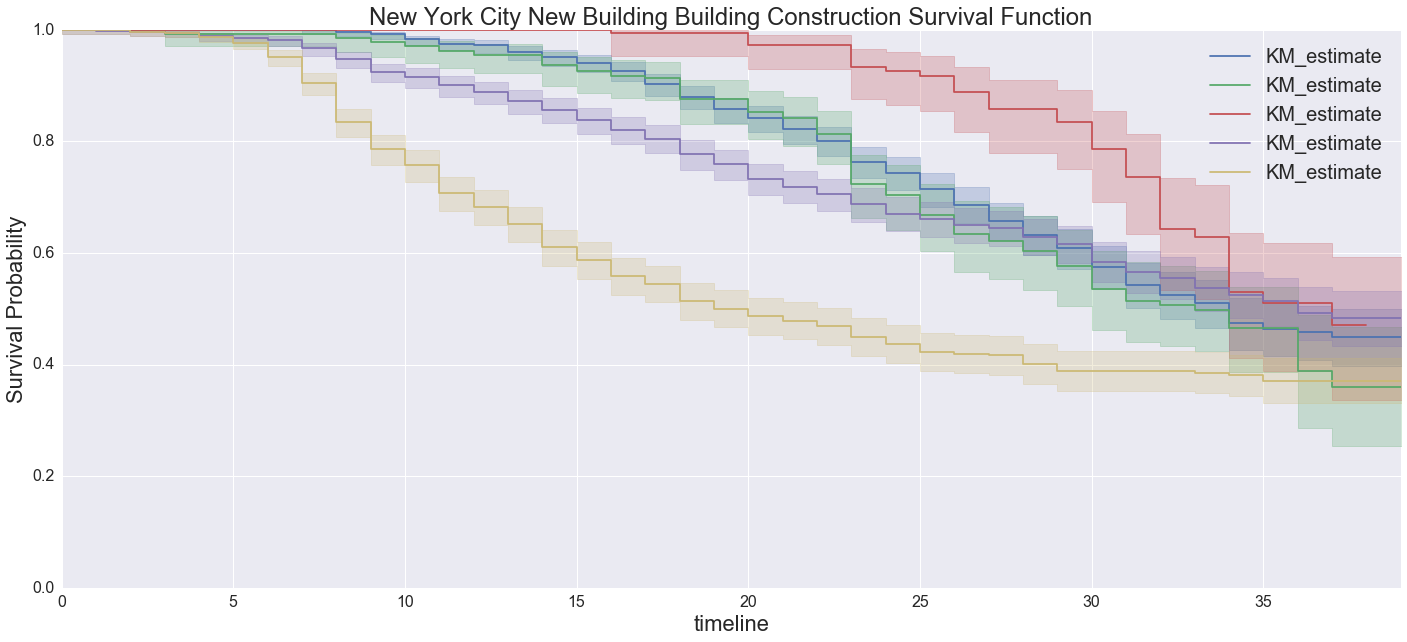

In [18]:
import lifelines
from lifelines.utils import datetimes_to_durations

sns.set(font_scale=2)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlabel('Months')
ax.set_ylabel('Survival Probability')
ax.set_ylim([0, 1])

for p_o in [p_o_bk, p_o_bx, p_o_mn, p_o_qn, p_o_si]:
    T, C = datetimes_to_durations(p_o['Issuance Date'], p_o['Certificate Date'], freq='M')
    p_o_kmf = lifelines.KaplanMeierFitter()
    p_o_kmf.fit(T, event_observed=C)
    p_o_kmf.plot(figsize=(24, 10), title='New York City New Building Building Construction Survival Function', fontsize=16, ax=ax)

PDF

(0, 1)

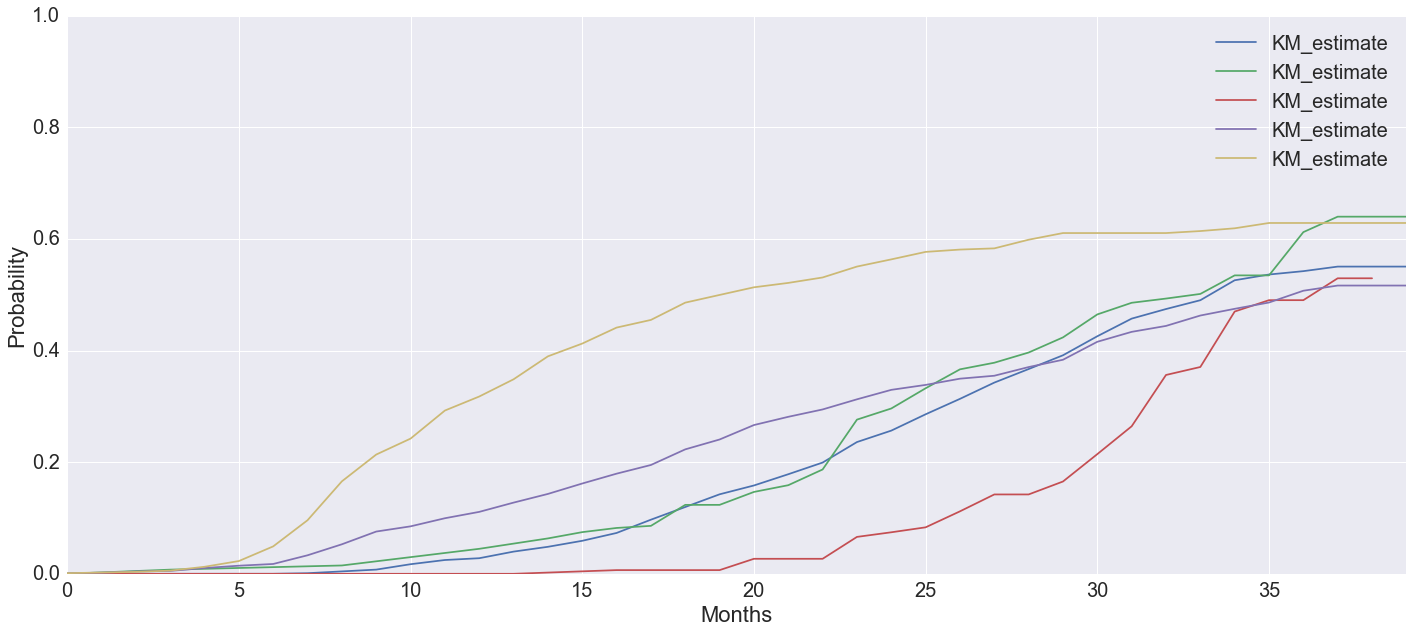

In [30]:
fig = plt.figure()
ax = fig.add_subplot(111)

for p_o in [p_o_bk, p_o_bx, p_o_mn, p_o_qn, p_o_si]:
    T, C = datetimes_to_durations(p_o['Issuance Date'], p_o['Certificate Date'], freq='M')
    p_o_kmf = lifelines.KaplanMeierFitter()
    p_o_kmf.fit(T, event_observed=C)
    (1 - p_o_kmf.survival_function_).plot(ax=ax, figsize=(24, 10))
    
ax.set_xlabel('Months')
ax.set_ylabel('Probability')
ax.set_ylim([0, 1])

Cleaned up (by hand for speed):

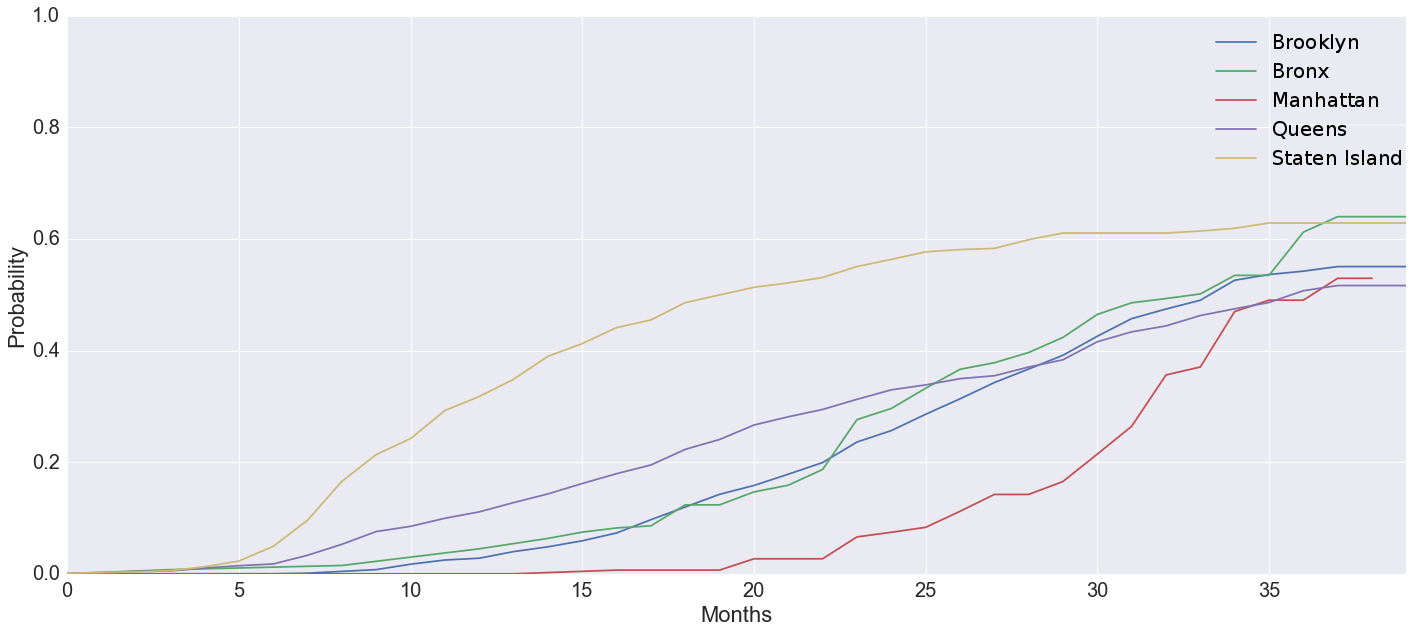

In [31]:
from IPython.display import Image

Image("../figures/construction_time_factors.png")

## Building type

In [25]:
p_o_data['Bldg Type'].value_counts()

1.0    2064
2.0    1130
Name: Bldg Type, dtype: int64

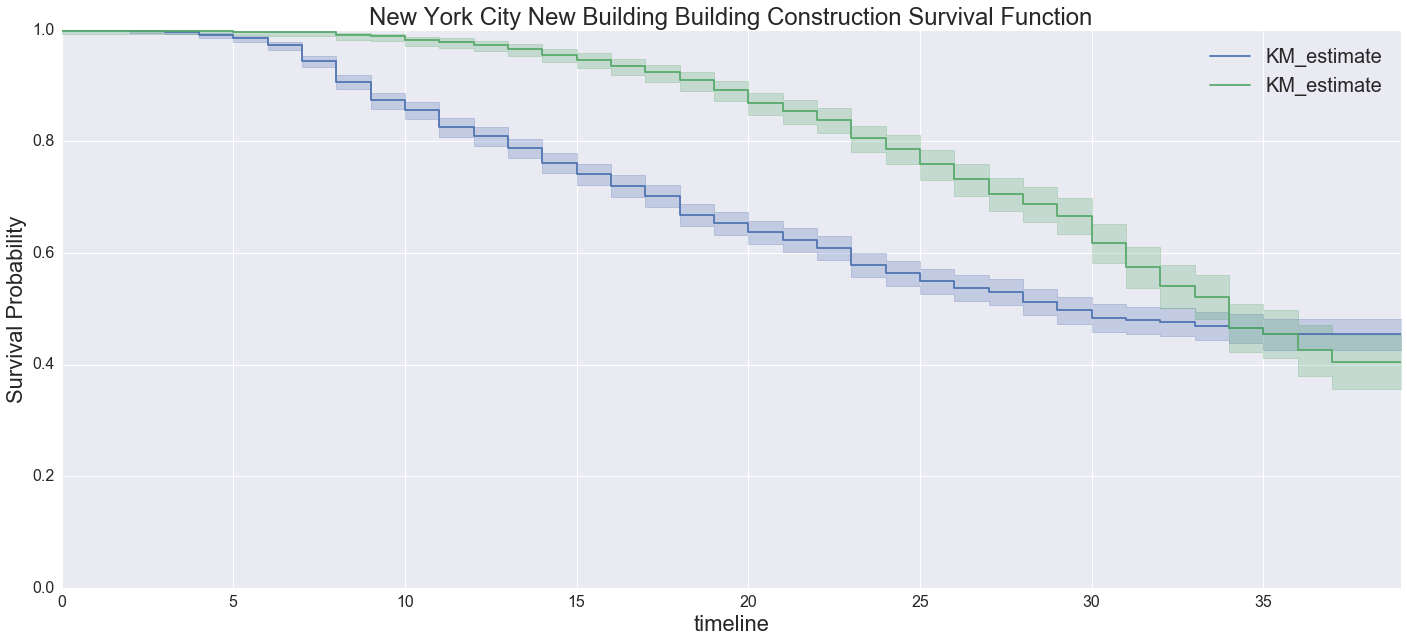

In [26]:
import lifelines
from lifelines.utils import datetimes_to_durations

sns.set(font_scale=2)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlabel('Months')
ax.set_ylabel('Survival Probability')
ax.set_ylim([0, 1])

for p_o in [p_o_data[p_o_data['Bldg Type'] == 1], p_o_data[p_o_data['Bldg Type'] == 2]]:
    T, C = datetimes_to_durations(p_o['Issuance Date'], p_o['Certificate Date'], freq='M')
    p_o_kmf = lifelines.KaplanMeierFitter()
    p_o_kmf.fit(T, event_observed=C)
    p_o_kmf.plot(figsize=(24, 10), title='New York City New Building Building Construction Survival Function', fontsize=16, ax=ax)

(0, 1)

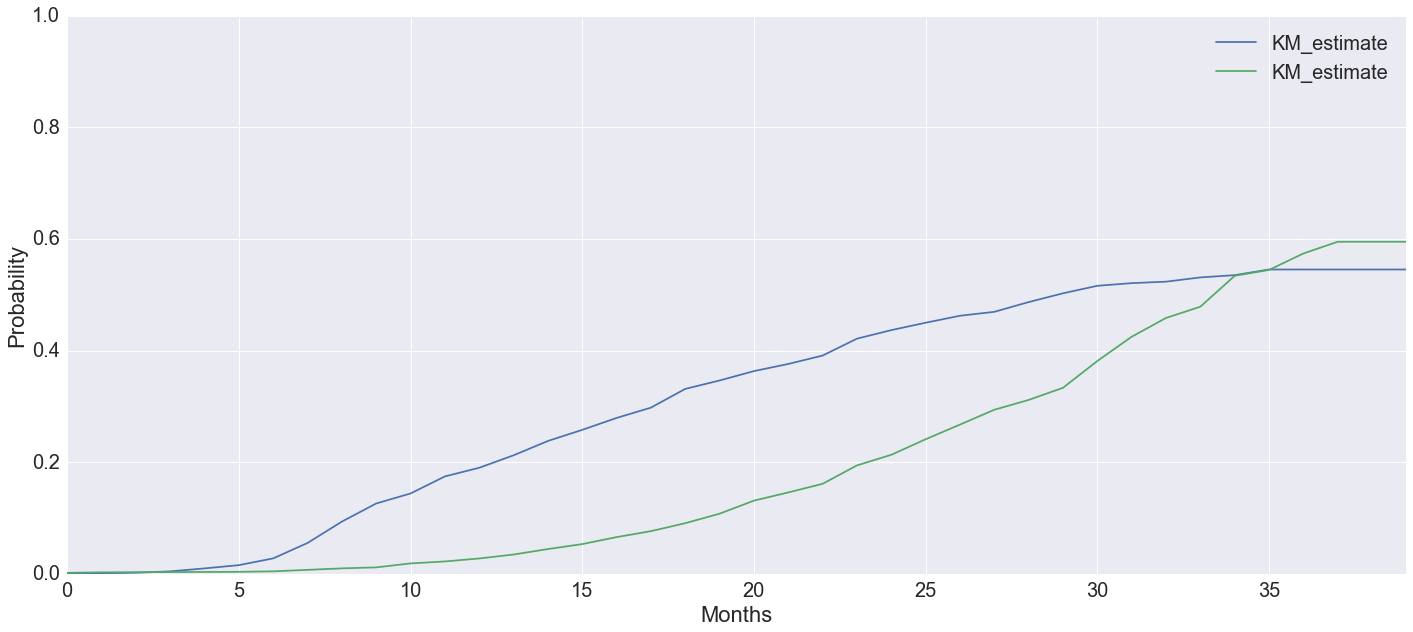

In [27]:
fig = plt.figure()
ax = fig.add_subplot(111)

for p_o in [p_o_data[p_o_data['Bldg Type'] == 1], p_o_data[p_o_data['Bldg Type'] == 2]]:
    T, C = datetimes_to_durations(p_o['Issuance Date'], p_o['Certificate Date'], freq='M')
    p_o_kmf = lifelines.KaplanMeierFitter()
    p_o_kmf.fit(T, event_observed=C)
    (1 - p_o_kmf.survival_function_).plot(ax=ax, figsize=(24, 10))
    
ax.set_xlabel('Months')
ax.set_ylabel('Probability')
ax.set_ylim([0, 1])